## 1 Functions and module

### 1.1 Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import seaborn as sns
import scipy.stats as SS
%matplotlib inline 
import copy
import random

In [2]:
pd.set_option('display.max_columns', None)

### 1.2 Functions

In [3]:
def calculate_empirical_ratio_distribution(group, n_simulations):
    """
    Calculate the 95th percentile of the size ratio distribution of two randomly selected tumor cell numbers
    within a given sample group. The ratio is defined as the larger cell number divided by the smaller, plus one
    to avoid division by zero.

    Parameters:
    - group (pd.DataFrame): The subgroup of the DataFrame corresponding to a specific sample.
    - n_simulations (int): The number of random pair selections and ratio calculations to perform.

    Returns:
    - pd.Series: A Series containing the 95th percentile boundary of the calculated ratios.
    """
    cell_numbers = group['Cell_number'].tolist()
    ratios = [(max(pair) / (min(pair) + 1)) for pair in [random.choices(cell_numbers, k=2) for _ in range(n_simulations)]]
    boundary_95th = np.quantile(ratios, 0.95)
    return pd.Series({'Boundary_95th': boundary_95th})

----

## 2 Input and output address

In [5]:
data_dir = "data/"
# read the miseq data for OncoNeg, PDAC and SCLC
Data_address = data_dir + 'Ca12a_Miseq_final_df.parquet'

---

## 3 Read all the data

In [6]:
All_data_df = pd.read_parquet(Data_address)

## 4 Tempalte shuffling for OncNeg

<font size="10" color="red"> Fig. S4(a-b)</font>

### 4.1 Read Data for TKO

In [7]:
TKO_df = All_data_df[All_data_df.Experiment=='OncNeg']

In [8]:
TKO_df.loc[TKO_df.Mouse_genotype.str.contains('Cas12a'),'Mouse_genotype'] = 'Cas12a'

In [9]:
input_df = TKO_df
cell_cutoff = 300
input_tissue = 'Lung'
Filtered_input_df = input_df[(input_df.Class=='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Lung')&(~input_df.Sample_ID.str.contains('B'))].copy()

### 4.2 Build a distribution for ratio

In [10]:
N_simulated = 10000

In [11]:
temp = Filtered_input_df.groupby('Sample_ID').apply(calculate_empirical_ratio_distribution, N_simulated).reset_index(level=0)
Ratio_dict = dict(zip(temp.Sample_ID,temp.Boundary_95th))

### 4.3 Calculate clonal barcodes associated with more than 1 sgRNA combinaitons

* <font size="5" color='blue'> I use 300 cell as a cutoff </font>
* <font size="5" color='blue'> What fraction of BC associated with only one sgRNAs </font>
* <font size="5" color='blue'> What fraction of reads belong to BC associated with only one sgRNAs </font>
* <font size="5" color='blue'> What fraction of reads if I only consider BC with major sgRNA combinaitons </font>

In [12]:
Input_df = Filtered_input_df
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'],as_index=False)['gRNA_combination'].count()
CT_df = CT_df[CT_df.gRNA_combination>1]
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False)['Clonal_barcode'].count().rename(columns={'Clonal_barcode':'Clonal_barcode_special'})

In [13]:
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'], as_index=False).agg(
    gRNA_combination=pd.NamedAgg(column='gRNA_combination', aggfunc=lambda x: len(x)),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x)),
    # For a given clonal barcode, I ask what are the total reads count of non-major BC
    None_major_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x.sort_values()[:-1]))
)
CT_df = CT_df[CT_df.gRNA_combination>1]

In [14]:
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False).agg(
    Clonal_barcode_special=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x)),
    Total_read_count_special = pd.NamedAgg(column='Total_read_count', aggfunc=lambda x: np.sum(x)),
    Total_none_major_read_count = pd.NamedAgg(column='None_major_read_count', aggfunc=lambda x: np.sum(x))
)

In [15]:
Barcode_s_df = Input_df.groupby(['Sample_ID','Mouse_genotype'],as_index=False).agg(
    Clonal_barcode=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x.unique())),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x))
)

In [16]:
Barcode_s_df = Barcode_s_df.merge(CT_df_s,on='Sample_ID', how='left')
Barcode_s_df = Barcode_s_df.fillna(0)
Barcode_s_df['Ratio_number'] = Barcode_s_df.Clonal_barcode_special/Barcode_s_df.Clonal_barcode
Barcode_s_df['Ratio_count'] = Barcode_s_df.Total_read_count_special/Barcode_s_df.Total_read_count
Barcode_s_df['Ratio_count_none_major'] = Barcode_s_df.Total_none_major_read_count/Barcode_s_df.Total_read_count

In [17]:
Barcode_s_df['Unique_BC_fraction'] = 1-Barcode_s_df.Ratio_number
Barcode_s_df['Remaining_tumor_burden_fraction'] = 1-Barcode_s_df.Ratio_count_none_major

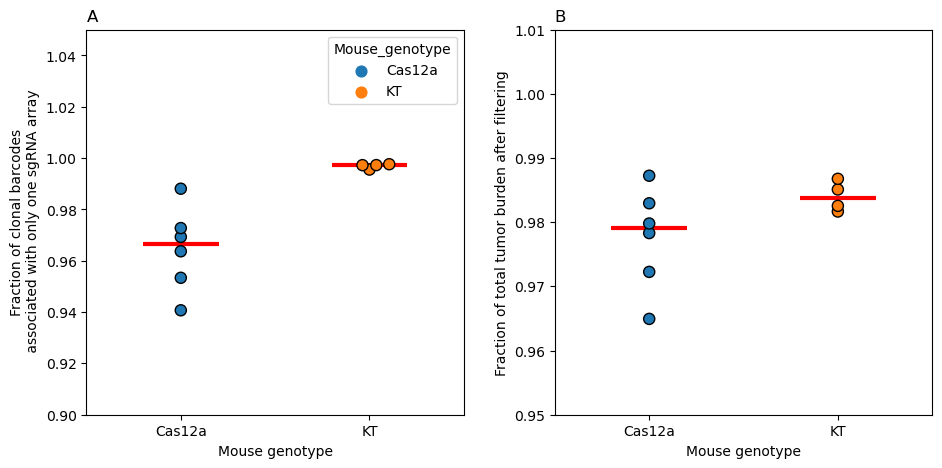

In [18]:
gs = gridspec.GridSpec(10, 23) 
fig1 = plt.figure(figsize=(23,5))
ax1=fig1.add_subplot(gs[:10, 0:5])
temp_p_df = Barcode_s_df
ix = 'Mouse_genotype'
iy = 'Unique_BC_fraction'
# panel A
# dot plot
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)

# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)

# set labels
ax1.set_ylabel('Fraction of clonal barcodes\n associated with only one sgRNA array')
ax1.set_xlabel('Mouse genotype')

ax1.set_ylim(0.9,1.05)
ax1.set_title('A', loc ='Left')
# ax1.get_legend().set_visible(False)

# panel B
ax1=fig1.add_subplot(gs[:10, 6:11])
ix = 'Mouse_genotype'
iy = 'Remaining_tumor_burden_fraction'
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# labels
ax1.set_ylabel('Fraction of total tumor burden after filtering')
ax1.set_xlabel('Mouse genotype')

ax1.set_ylim(0.95,1.01)
ax1.set_title('B', loc ='Left')
ax1.get_legend().set_visible(False)


## 5. Tempalte shuffling for SCLC

<font size="10" color="red"> Fig. S4(c-d)</font>

### 5.1 Read Data for SCLC

In [19]:
SCLC_df = All_data_df[All_data_df.Experiment=='SCLC']

In [20]:
SCLC_df.Mouse_genotype.unique()

array(['Cas12a', 'TKO'], dtype=object)

In [21]:
input_df = SCLC_df.copy()
input_df['Unique_id'] = input_df['Sample_ID'] + input_df['gRNA_clonalbarcode']
cell_cutoff = 300
input_tissue = 'Lung'

In [22]:
df1 = input_df[(input_df.Class=='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Lung')&(~input_df.Sample_ID.str.contains('B'))].copy()
df2 = input_df[(input_df.Class!='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Lung')&(~input_df.Sample_ID.str.contains('B'))].copy()

In [23]:
# Sort DataFrames by 'Mouse' and 'tumor_size'
df1 = df1.sort_values(by=['Sample_ID', 'Cell_number'])
df2 = df2.sort_values(by=['Sample_ID', 'Cell_number'])

# Initialize a set to keep track of indices from df1 that have been matched and should be removed
indices_to_drop = set()

# Iterate over each row in df2 using itertuples for faster row access
for row in df2.itertuples(index=False):
    # Find the subset of df1 that matches the current 'Mouse' and hasn't been matched yet
    subset_df1 = df1[(df1['Sample_ID'] == row.Sample_ID) & (~df1.index.isin(indices_to_drop))]

    if not subset_df1.empty:
        # Find the row in this subset with the nearest 'tumor_size' to the current row in df2
        nearest_idx = (subset_df1['Cell_number'] - row.Cell_number).abs().idxmin()
        
        # Add the index of the matched row to the set of indices to drop
        indices_to_drop.add(nearest_idx)

# Drop the matched rows from df1
df1_filtered = df1.drop(index=indices_to_drop)

In [24]:
SCLC_df_filtered = df1_filtered

In [25]:
Filtered_input_df = SCLC_df_filtered

### 5.2 Build a distribution for ratio

In [26]:
N_simulated = 10000

In [27]:
temp = Filtered_input_df.groupby('Sample_ID').apply(calculate_empirical_ratio_distribution, N_simulated).reset_index(level=0)
Ratio_dict = dict(zip(temp.Sample_ID,temp.Boundary_95th))

### 5.3 Calculate clonal barcodes associated with more than 1 sgRNA combinaitons

In [28]:
# Input_df = input_df[(input_df.Count>1)&(input_df.Class=='Original')]
Input_df = Filtered_input_df
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'],as_index=False)['gRNA_combination'].count()
CT_df = CT_df[CT_df.gRNA_combination>1]
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False)['Clonal_barcode'].count().rename(columns={'Clonal_barcode':'Clonal_barcode_special'})

In [29]:
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'], as_index=False).agg(
    gRNA_combination=pd.NamedAgg(column='gRNA_combination', aggfunc=lambda x: len(x)),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x)),
    # For a given clonal barcode, I ask what are the total reads count of non-major BC
    None_major_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x.sort_values()[:-1]))
)
CT_df = CT_df[CT_df.gRNA_combination>1]

In [30]:
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False).agg(
    Clonal_barcode_special=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x)),
    Total_read_count_special = pd.NamedAgg(column='Total_read_count', aggfunc=lambda x: np.sum(x)),
    Total_none_major_read_count = pd.NamedAgg(column='None_major_read_count', aggfunc=lambda x: np.sum(x))
)

In [31]:
Barcode_s_df = Input_df.groupby(['Sample_ID','Mouse_genotype'],as_index=False).agg(
    Clonal_barcode=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x.unique())),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x))
)

In [32]:
Barcode_s_df = Barcode_s_df.merge(CT_df_s,on='Sample_ID', how='left')
Barcode_s_df = Barcode_s_df.fillna(0)
Barcode_s_df['Ratio_number'] = Barcode_s_df.Clonal_barcode_special/Barcode_s_df.Clonal_barcode
Barcode_s_df['Ratio_count'] = Barcode_s_df.Total_read_count_special/Barcode_s_df.Total_read_count
Barcode_s_df['Ratio_count_none_major'] = Barcode_s_df.Total_none_major_read_count/Barcode_s_df.Total_read_count

In [33]:
Barcode_s_df['Unique_BC_fraction'] = 1-Barcode_s_df.Ratio_number
Barcode_s_df['Remaining_tumor_burden_fraction'] = 1-Barcode_s_df.Ratio_count_none_major

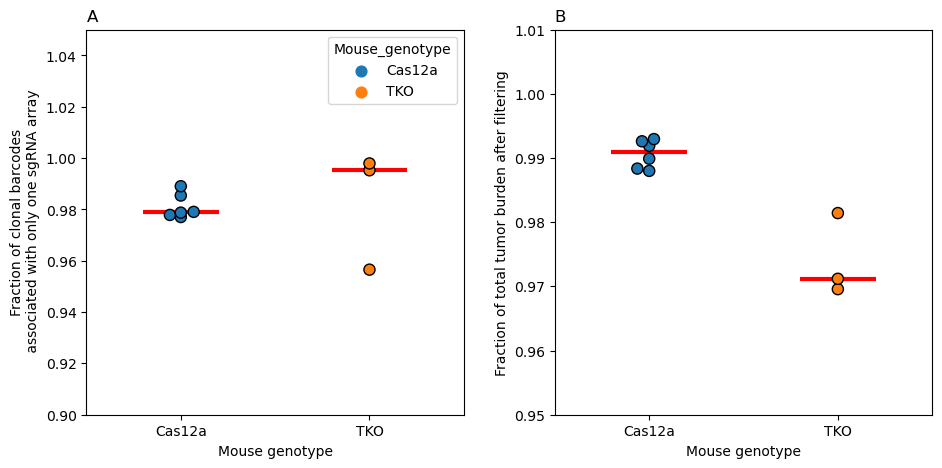

In [34]:
gs = gridspec.GridSpec(10, 23) 
fig1 = plt.figure(figsize=(23,5))
ax1=fig1.add_subplot(gs[:10, 0:5])
temp_p_df = Barcode_s_df
ix = 'Mouse_genotype'
iy = 'Unique_BC_fraction'
# panel A
# dot plot
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)

# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)

# set labels
ax1.set_ylabel('Fraction of clonal barcodes\n associated with only one sgRNA array')
ax1.set_xlabel('Mouse genotype')
# da1 = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a'][iy].to_list()
# da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
# temp = SS.ranksums(da1,da2)
# # temp = SS.ttest_ind(da1, da2)
# ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0.9,1.05)
ax1.set_title('A', loc ='Left')
# ax1.get_legend().set_visible(False)

# panel B
ax1=fig1.add_subplot(gs[:10, 6:11])
ix = 'Mouse_genotype'
iy = 'Remaining_tumor_burden_fraction'
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# labels
ax1.set_ylabel('Fraction of total tumor burden after filtering')
ax1.set_xlabel('Mouse genotype')
# da1 = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a'][iy].to_list()
# da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
# temp = SS.ranksums(da1,da2)
# # temp = SS.ttest_ind(da1, da2)
# ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0.95,1.01)
ax1.set_title('B', loc ='Left')
ax1.get_legend().set_visible(False)

---

## 6 Tempalte shuffling for PDAC

<font size="10" color="red"> Fig. S4(e-f)</font>

### 6.1 Read Data for PDAC

In [36]:
PDAC_df =  All_data_df[All_data_df.Experiment=='PDAC'].copy()

In [37]:
PDAC_df[PDAC_df.Sample_ID=='LA75_70'].shape

(459, 25)

In [38]:
PDAC_df.loc[PDAC_df.Mouse_genotype=='Kras/+;Tomato/+;LSL-Cas12a/+','Mouse_genotype'] = 'Kras_Cas12aHET'

In [39]:
PDAC_df.loc[PDAC_df.Mouse_genotype=='LSL-Cas12a','Mouse_genotype'] = 'Cas12a'

In [40]:
tt_list = []
for x,y in zip(PDAC_df.Sample_ID.to_list(),PDAC_df.Mouse_genotype.to_list()):
    if x == 'LA75_70':
        temp = 'Cas12a'
    elif x == 'LA75_74':
        temp = 'Kras_Cas12aHET'
    else:
        temp=y
    tt_list.append(temp)

PDAC_df.Mouse_genotype = tt_list

In [41]:
input_df = PDAC_df
cell_cutoff = 300
input_tissue = 'Pancreas'
Filtered_input_df = input_df[(input_df.Class=='Original')&(input_df.Cell_number>cell_cutoff)&(input_df.Tissue=='Pancreas')&(~input_df.Sample_ID.str.contains('B'))].copy()

### 6.2 Build a distribution for ratio

In [42]:
N_simulated = 10000

In [43]:
temp = Filtered_input_df.groupby('Sample_ID').apply(calculate_empirical_ratio_distribution, N_simulated).reset_index(level=0)
Ratio_dict = dict(zip(temp.Sample_ID,temp.Boundary_95th))

### 6.3 Calculate clonal barcodes associated with more than 1 sgRNA combinaitons

In [50]:
# Input_df = input_df[(input_df.Count>1)&(input_df.Class=='Original')]
Input_df = Filtered_input_df
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'],as_index=False)['gRNA_combination'].count()
CT_df = CT_df[CT_df.gRNA_combination>1]
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False)['Clonal_barcode'].count().rename(columns={'Clonal_barcode':'Clonal_barcode_special'})

In [51]:
CT_df = Input_df.groupby(['Sample_ID','Clonal_barcode'], as_index=False).agg(
    gRNA_combination=pd.NamedAgg(column='gRNA_combination', aggfunc=lambda x: len(x)),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x)),
    # For a given clonal barcode, I ask what are the total reads count of non-major BC
    None_major_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x.sort_values()[:-1]))
)
CT_df = CT_df[CT_df.gRNA_combination>1]

In [52]:
CT_df_s = CT_df.groupby(['Sample_ID'],as_index=False).agg(
    Clonal_barcode_special=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x)),
    Total_read_count_special = pd.NamedAgg(column='Total_read_count', aggfunc=lambda x: np.sum(x)),
    Total_none_major_read_count = pd.NamedAgg(column='None_major_read_count', aggfunc=lambda x: np.sum(x))
)

In [53]:
Barcode_s_df = Input_df.groupby(['Sample_ID','Mouse_genotype'],as_index=False).agg(
    Clonal_barcode=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x.unique())),
    Total_read_count = pd.NamedAgg(column='Count', aggfunc=lambda x: np.sum(x))
)

In [54]:
Barcode_s_df = Barcode_s_df.merge(CT_df_s,on='Sample_ID', how='left')
Barcode_s_df = Barcode_s_df.fillna(0)
Barcode_s_df['Ratio_number'] = Barcode_s_df.Clonal_barcode_special/Barcode_s_df.Clonal_barcode
Barcode_s_df['Ratio_count'] = Barcode_s_df.Total_read_count_special/Barcode_s_df.Total_read_count
Barcode_s_df['Ratio_count_none_major'] = Barcode_s_df.Total_none_major_read_count/Barcode_s_df.Total_read_count

In [55]:
Barcode_s_df['Unique_BC_fraction'] = 1-Barcode_s_df.Ratio_number
Barcode_s_df['Remaining_tumor_burden_fraction'] = 1-Barcode_s_df.Ratio_count_none_major

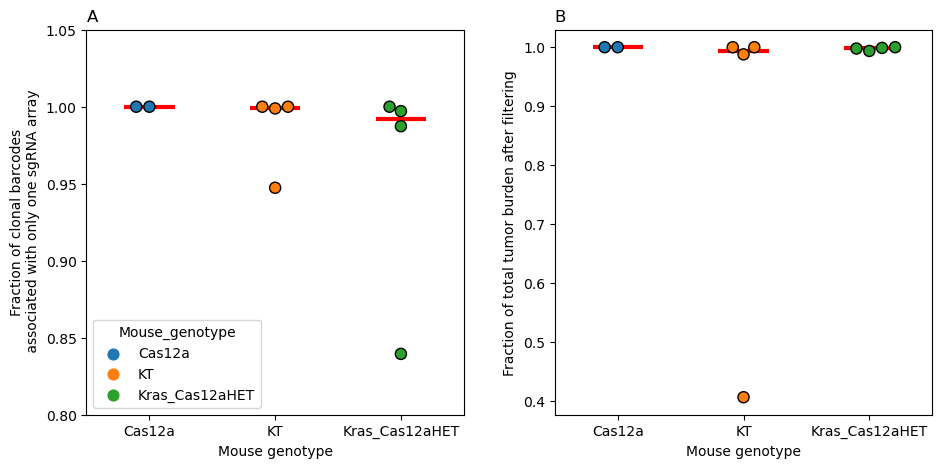

In [58]:
gs = gridspec.GridSpec(10, 23) 
fig1 = plt.figure(figsize=(23,5))
ax1=fig1.add_subplot(gs[:10, 0:5])
temp_p_df = Barcode_s_df.sort_values(by='Mouse_genotype')
ix = 'Mouse_genotype'
iy = 'Unique_BC_fraction'
# panel A
# dot plot
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)

# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)

# set labels
ax1.set_ylabel('Fraction of clonal barcodes\n associated with only one sgRNA array')
ax1.set_xlabel('Mouse genotype')
# da1 = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a'][iy].to_list()
# da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
# temp = SS.ranksums(da1,da2)
# # temp = SS.ttest_ind(da1, da2)
# ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0.80,1.05)
ax1.set_title('A', loc ='Left')
# ax1.get_legend().set_visible(False)

# panel B
ax1=fig1.add_subplot(gs[:10, 6:11])
ix = 'Mouse_genotype'
iy = 'Remaining_tumor_burden_fraction'
sns.swarmplot(x=ix, y=iy, data=temp_p_df,
              ax=ax1, size=8,hue='Mouse_genotype',edgecolor="black", linewidth=1)
# add mean line
category_means = temp_p_df.groupby(ix)[iy].median().reset_index()
# Loop through each category and draw a horizontal line for its mean
for index, row in category_means.iterrows():
    # Get the positions of the x-ticks
    xticks = ax1.get_xticks()
    if row[ix] in temp_p_df[ix].values:
        # Find the position of the current category in the x-ticks
        ix_position = list(temp_p_df[ix].unique()).index(row[ix])
        # Draw a horizontal line for this category's mean
        ax1.hlines(row[iy], xticks[ix_position] - 0.2, xticks[ix_position] + 0.2, color='r', linestyle='-',linewidth=3)
# labels
ax1.set_ylabel('Fraction of total tumor burden after filtering')
ax1.set_xlabel('Mouse genotype')
# da1 = temp_p_df[temp_p_df.Mouse_genotype=='Cas12a'][iy].to_list()
# da2 = temp_p_df[temp_p_df.Mouse_genotype=='KT'][iy].to_list()
# temp = SS.ranksums(da1,da2)
# # temp = SS.ttest_ind(da1, da2)
# ax1.text(0.8,1.05, "$\it{p-value}$ =" + f" {temp[1]:.3f}", size=10, ha="right",verticalalignment='center', transform=ax1.transAxes)
# ax1.set_ylim(0.9,1.01)
ax1.set_title('B', loc ='Left')
ax1.get_legend().set_visible(False)

